# **CSE4022: Natural Language Proccessing J Component (Slot:B2)**
## **Project Title:** Automatic Story Generation
### **Team Members:**
1.   Talatala Rahul Reddy  (19BCE1778)
2.   Pulimi Bhargava Reddy (19BCE1342)

#### In this notebook we have trained the GRU Model on multiple short stories

### Importing Libraries & Downloading Dependecies

In [ ]:
#%tensorflow_version 2.x  #selects the tensorflow 2.0+ version
import tensorflow as tf
import string
import requests
import nltk
import bs4
import re
import nltk
nltk.download('punkt')
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Embedding, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Scraping the Short Stories Website http://www.classicshorts.com/ to train the above models

In [ ]:
#return bs4 object
def getPage(url,headers):
    res = requests.get(url, headers=headers)
    try:
        res.raise_for_status()
    except:
        pass
    pageHtml=bs4.BeautifulSoup(res.text,'html.parser')
    return pageHtml

#check if previous scrape already contained the given listing
def getStoryText(link):
    regex = re.compile(r'[\n\r\t]')
    headers = {'User-Agent': 'Mozilla/5.0'}
    pageHtml=getPage(link,headers)
    elems = pageHtml.find_all("div", class_="StoryPara")
    totalText = ""
    for e in elems:
        totalText += regex.sub(" ", e.text.strip())
    return totalText

# Returns an array of dcitionaries - turnip listings
def getListings():
    no_of_stories = 0
    badTitles = {'tlrm','fiddler','frog','ItalianMaster','luck'}
    #f = open("short_stories.txt", "a", encoding='utf-8')
    url = "http://www.classicshorts.com/bib.html"
    headers = {'User-Agent': 'Mozilla/5.0'}
    storyTexts = []
    rawText = ""
    pageHtml=getPage(url,headers)
    elems = pageHtml.find_all("div", class_="biolisting")
    for e in elems:
        currentUrl = "http://www.classicshorts.com/stories/"+e.attrs['onclick'][11:-2]+".html"
        if e.attrs['onclick'][11:-2] not in badTitles:
            pog = getStoryText(currentUrl)
            storyTexts.append(pog)
            no_of_stories = no_of_stories + 1
            #print("No of Stories:"+str(no_of_stories))
            rawText += pog
        if no_of_stories == 100:
            break
        
    #print("Len of story texts:"+str(len(storyTexts)))
    #print("No of stories:"+str(no_of_stories))
    #print(storyTexts)
    #f.write(rawText)
    #f.close()
    return rawText

In [ ]:
#fetching the short stories by scraping
stories = getListings()
stories = stories[81:]
len(stories)

1983654

### Sentence Tokenising the short-stories

In [ ]:
#performing sentence tokenisation
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(stories)
len(sentences)

20516

In [ ]:
#displays first 3 sentences
sentences[:3]

['My Dear Sir: I am happy to assure you that your anxiety is without reason.',
 'Flemming will be confined to the sofa for three or four weeks, and will have to be careful at first how he uses his leg.',
 'A fracture of this kind is always a tedious affair.']

### Tokenising the short stories and cleaning the data

In [ ]:
#cleaning the dataset
def clean_text(sentences):
    #creating tokens from the document
    tokens = []
    for sentence in sentences:
      tokens.extend(nltk.word_tokenize(sentence))
    punc = str.maketrans('','',string.punctuation)
    #this list will remove punctuations
    tokens = [ x.translate(punc) for x in tokens]
    #this list will remove special characters
    tokens = [ x for x in tokens if x.isalpha()]
    #this list converts all the words to lowercase
    tokens = [ x.lower() for x in tokens]
    return tokens

In [ ]:
tokens = clean_text(sentences)

In [ ]:
tokens[:10]

['my', 'dear', 'sir', 'i', 'am', 'happy', 'to', 'assure', 'you', 'that']

In [ ]:
len(tokens) #no of tokens in the 100 short stories

364182

In [ ]:
len(set(tokens)) #no of unique words in the 100 short stories

21957

### Generating sequence of tokens

In [ ]:
#creating the sequence of tokens
length = 50 + 1 #first 50 words as input and 1 as the output
lines = []

for i in range(length,len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    lines.append(line)
    if i > 110000: #we're only taking few tokens as input for the model
        break

In [ ]:
len(lines)

109951

In [ ]:
lines[:4]

['my dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately',
 'dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the',
 'sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the bone',
 'i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a ted

### Converting tokens to numerical values

In [ ]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(lines) 
#performing tokenisation on the seq of words (lines) and these seq of words are embedded as integers basically word embedding
#every unique token(word) is given an integer as ML model only works on numerical values
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
tokenizer.word_index 

{'the': 1,
 'and': 2,
 'of': 3,
 'a': 4,
 'to': 5,
 'he': 6,
 'in': 7,
 'was': 8,
 'i': 9,
 'his': 10,
 'it': 11,
 'that': 12,
 'had': 13,
 'with': 14,
 'you': 15,
 'she': 16,
 'on': 17,
 'at': 18,
 'her': 19,
 'as': 20,
 's': 21,
 'for': 22,
 'him': 23,
 'not': 24,
 'but': 25,
 'is': 26,
 'they': 27,
 'from': 28,
 'were': 29,
 'my': 30,
 'said': 31,
 'there': 32,
 'be': 33,
 'all': 34,
 'by': 35,
 'one': 36,
 'have': 37,
 'me': 38,
 'would': 39,
 'nt': 40,
 'an': 41,
 'no': 42,
 'out': 43,
 'up': 44,
 'this': 45,
 'which': 46,
 'what': 47,
 'when': 48,
 'man': 49,
 'we': 50,
 'so': 51,
 'do': 52,
 'them': 53,
 'then': 54,
 'into': 55,
 'or': 56,
 'their': 57,
 'could': 58,
 'now': 59,
 'if': 60,
 'been': 61,
 'like': 62,
 'are': 63,
 'did': 64,
 'about': 65,
 'down': 66,
 'who': 67,
 'your': 68,
 'some': 69,
 'little': 70,
 'over': 71,
 'only': 72,
 'will': 73,
 'eyes': 74,
 'time': 75,
 'more': 76,
 'old': 77,
 'very': 78,
 'back': 79,
 'made': 80,
 'come': 81,
 'again': 82,
 'know':

In [ ]:
sequences = np.array(sequences)

In [ ]:
sequences[:2]
#it is a 2d array
#rows represent the line of the short stories
#column represent the words (there are 51 cols)

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703,  2805],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805,     1]])

In [ ]:
sequences.shape #51 cols are words where we take first 50 cols(words) as x and last col(word) as y

(109951, 51)

### Preparing data to that has to fed into the model

In [ ]:
#first 50 tokens(words) are x and last tokens is y
X,y = sequences[:,:-1] , sequences[:,-1]
#sequences[:,-1] selects only the last col
#sequences[:,:-1] selects all cols except the last col

In [ ]:
X[:2]

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805]])

In [ ]:
y[:2]

array([2805,    1])

In [ ]:
vocabulary_size = len(tokenizer.word_index) + 1 #1 as it's stating from 1 (that word_index is from 1)
vocabulary_size

11638

In [ ]:
y = to_categorical(y,num_classes=vocabulary_size)
# a numpy array/vector which has integers that represent different categories is converted into a numpy array/matrix 
#which has binary values and has columns equal to the number of categories in the data.
#X.shape[1] is 50
seq_length = X.shape[1]

### Creating a function to generate stories from a given seed text

In [ ]:
def generate_story(model,tokenizer,text_seq_len,seed_text,n_words):
  text = []
  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    #the model expects the input(sentences) to be of same length hence we use the pad_sequences
    #pre it adds 0 before the sentence
    encoded = pad_sequences([encoded],maxlen=text_seq_len,padding='pre')

    pred = model.predict(encoded) 
    y_pred = np.argmax(pred,axis=1)
    predicted_word = ''
    for word,index in tokenizer.word_index.items():
      if index == y_pred:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)

###Training the GRU Model

In [ ]:
gru = Sequential()
#input layer
gru.add(Embedding(vocabulary_size,50,input_length=seq_length))
#hidden layer 1 (GRU layer)
gru.add(GRU(100,return_sequences=True))
gru.add(Dropout(0.2))
#hidden layer 2 (GRU layer)
gru.add(GRU(120))
#hidden layer 3 (dense layer)
gru.add(Dense(140,activation='relu'))
#output layer
gru.add(Dense(vocabulary_size,activation='softmax'))#units=vocab size bcoz we want probability for each predicted word

In [ ]:
gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            581900    
                                                                 
 gru (GRU)                   (None, 50, 100)           45600     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 120)               79920     
                                                                 
 dense (Dense)               (None, 140)               16940     
                                                                 
 dense_1 (Dense)             (None, 11638)             1640958   
                                                                 
Total params: 2,365,318
Trainable params: 2,365,318
Non-

In [ ]:
gru.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
gru_history = gru.fit(X,y,batch_size=256,epochs=150)

Epoch 1/150
430/430 [==============================] - 29s 50ms/step - loss: 7.0155 - accuracy: 0.0646
Epoch 2/150
430/430 [==============================] - 21s 50ms/step - loss: 6.6215 - accuracy: 0.0650
Epoch 3/150
430/430 [==============================] - 21s 50ms/step - loss: 6.3763 - accuracy: 0.0791
Epoch 4/150
430/430 [==============================] - 21s 49ms/step - loss: 6.0545 - accuracy: 0.0998
Epoch 5/150
430/430 [==============================] - 21s 50ms/step - loss: 5.7872 - accuracy: 0.1166
Epoch 6/150
430/430 [==============================] - 21s 50ms/step - loss: 5.5764 - accuracy: 0.1294
Epoch 7/150
430/430 [==============================] - 22s 50ms/step - loss: 5.3980 - accuracy: 0.1381
Epoch 8/150
430/430 [==============================] - 22s 50ms/step - loss: 5.2394 - accuracy: 0.1437
Epoch 9/150
430/430 [==============================] - 22s 50ms/step - loss: 5.0833 - accuracy: 0.1500
Epoch 10/150
430/430 [==============================] - 22s 50ms/step - l

In [ ]:
gru.save('./GRU.h5')

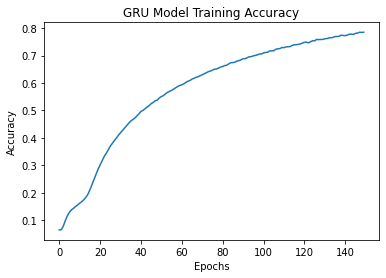

In [ ]:
import matplotlib.pyplot as plt
epochs = range(len(gru_history.history['accuracy']))
plt.plot(epochs,gru_history.history['accuracy'])
plt.title("GRU Model Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.show()

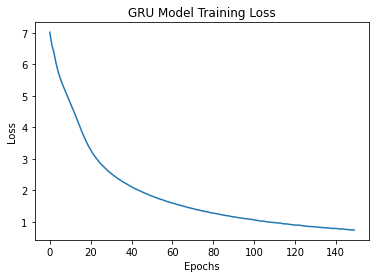

In [ ]:
plt.plot(epochs,gru_history.history['loss'])
plt.title("GRU Model Training Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()

### Generating Stories from GRU Model

In [ ]:
seed_text = "The country was in chaos but"
generate_story(gru, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'downcast he got down to her eyes and think that do they get to eating in rubbing fish while mother that bound when they bring him round the doorstep with coatcollar turned out and then then it went out on the bed and went out rather arms and saw the'

In [ ]:
seed_text = "I walked out of the store dissatisfied and it"
generate_story(gru, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'had suffered away in any mood s little times violent son and drove out a quarter of a deep black holes off the swamp beyond the deep fields of gate the phalanx of women in their front only fire in which they had passed the difficulty of interest and drinking'

In [ ]:
seed_text = "The lady was known as a soothsayer - a psychic of sorts. The rubbing of her crystal ball was finalized as she completed her prophecy. Her hands were wrinkled and dirty, a strange companion to the polish of the ball she held in her hands."
generate_story(gru, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'the panther looked into one of silence when the doctor said she had heard his folly and liked his mind without discomfort was a few weeks there and the doctor later crying and switching up his every morning and sat out her dick had sat between his astonished and stumpy'

In [ ]:
seed_text = "Little Chandler's thoughts ever since lunch-time had been of his meeting with Gallaher, of Gallaher's invitation, and of the great city London where Gallaher lived. He was called Little Chandler because"
generate_story(gru, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'that was unnecessary to have at all their own people of the graceful enchanting man buildings and as she had made the carcass at the stranger asked as he observed them that it would be effort to accept the own to force to pieces a wife with hot to dear seen to tell what his dear fellow of a sledgehammer that she had told me now because it s rather to queen at this years he had only used to give him a kitten mamma is at any service of your own daughter well just hearing of its service s'

In [ ]:
seed_text = "On the morning of the fifth of September, in uniform, his revolver on the table, the colonel addressed his soliders and"
generate_story(gru, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'friends with pearls but making its discouraged gray dogs his suppers the mouth of his mouth as he remembered that he must lay no voice gasping for look about from this he was climbed behind the people out of you do nt be alarmed said the sea gnashing its hands they were standing in the right to each other six minutes before he was sitting there in the air she was dressed in the lightness of a short corridor glass there on the handle of the table there was no longer the fact and warm that there were no time'

In [ ]:
seed_text = "On Christmas Eve around 1978, when I was a young boy, after having the traditional pastry and cookies and after having sung around the fire, I, with my sister, my mother and my aunts, and Emma Jackman and her son, got into Emma Jackman's car and then later"
generate_story(gru, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'as my spirits are not well we need nt jar the old gentleman you much all the first look in the evening s hand the general nodded to him a lot of wild taking a look is there but no more charlie to think it is it she has a job in his legs but he needs put his shoulders and was on the least sign of pain and now struck out tea in the office uncle who grew about when she fell they are all to do with many money filled again do nt understand you pay him the'